In [22]:
# Imports and settings

from MatrixFactor import *
from actions import *
from Graph import *
from expansions import *
from helpers import *
from Texable import render, tex_with_macros
from IPython.display import display, Latex
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

plt.rc(
    "text.latex",
    preamble=r"""
\usepackage{amsfonts}
\usepackage{amsmath}
\usepackage{mathtools}
\newcommand{\avg}[1]{\mathopen{}\left\langle #1 \right\rangle\mathclose{}}
\newcommand{\p}[1]{\mathopen{}\left\lparen #1 \right\rparen\mathclose{}}
\newcommand{\conj}[1]{\overline{#1}}
\newcommand{\G}{\widetilde{G}}
\newcommand{\E}{\mathbb{E}}
""",
)

In [23]:
# Better size

from math import floor
from Graph import p, q, k


def size2(x: Graph):
    px, qx = p(x), q(x)
    loops = sum([floor(3 * k(t) / 2) - 2 for t in x.g_loops])

    return Size(
        -(px + qx),
        -(qx + loops)
        - len([c for c in x.coefficients if isinstance(c, ImF) and c.a == 1]),
    )

In [91]:
# Visualize graphs

from matplotlib.axes import Axes

conjugate_color = "#DD5746"
non_conjugate_color = "#4793AF"


def visualize(x: Graph, ax: Axes):
    g = nx.DiGraph()
    curr_loop_center = 0
    pos = {}

    light_weight_edges = []
    for t in x.light_weights:
        g_factor = t.factors[0]
        u = (curr_loop_center, 0)

        light_weight_edges.append((u, u))
        pos[u] = (curr_loop_center, 0)
        g.add_node(
            u, color=conjugate_color if g_factor.conjugated else non_conjugate_color
        )
        g.add_edge(
            u, u, color=conjugate_color if g_factor.conjugated else non_conjugate_color
        )

        curr_loop_center += 0.5

    two_g_loop_edges = []
    g_loop_edges = []
    for t in x.g_loops:
        g_factors = [f for f in t.factors if isinstance(f, G)]

        # Each loop is centered at (curr_loop_center, 0)
        cx = curr_loop_center
        cy = 0
        r = 0.25
        theta = np.linspace(0, 2 * np.pi, len(g_factors) + 1)
        dx = r * np.cos(theta)
        dy = r * np.sin(theta)

        for j, f in enumerate(g_factors):
            u = (curr_loop_center, j)
            v = (curr_loop_center, (j + 1) % len(g_factors))

            if len(g_factors) == 2:
                two_g_loop_edges.append((u, v))
            else:
                g_loop_edges.append((u, v))
            pos[u] = (cx + dx[j], cy + dy[j])
            g.add_node(
                u, color=conjugate_color if f.conjugated else non_conjugate_color
            )
            g.add_edge(
                u, v, color=conjugate_color if f.conjugated else non_conjugate_color
            )

        curr_loop_center += 0.75

    nx.draw_networkx_nodes(
        g,
        pos=pos,
        ax=ax,
        node_size=30,
        node_color=[g.nodes[u]["color"] for u in g.nodes()],  # type: ignore
    )

    # Draw light-weights
    nx.draw_networkx_edges(
        g,
        ax=ax,
        pos=pos,
        edgelist=light_weight_edges,
        edge_color=[g.edges[u, v]["color"] for u, v in light_weight_edges],  # type: ignore
        width=3.0,
        arrowsize=15,
        arrowstyle="-",
        style=":"
    )

    # Draw length-2 G-loops
    nx.draw_networkx_edges(
        g,
        ax=ax,
        pos=pos,
        edgelist=two_g_loop_edges,
        edge_color=[g.edges[u, v]["color"] for u, v in two_g_loop_edges],  # type: ignore
        width=3.0,
        arrowsize=15,
        connectionstyle="arc3,rad=0.5",
        node_size=30,
    )

    # Draw remaining G-loops
    nx.draw_networkx_edges(
        g,
        ax=ax,
        pos=pos,
        edgelist=g_loop_edges,
        edge_color=[g.edges[u, v]["color"] for u, v in g_loop_edges],  # type: ignore
        width=3.0,
        arrowsize=15,
        connectionstyle="arc3,rad=0.1",
        node_size=30,
    )

    nx.draw_networkx_edges

# Expansion to Order $\frac{1}{N^m}$


<IPython.core.display.Latex object>

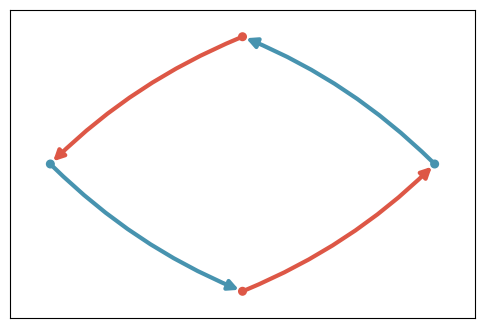

<IPython.core.display.Latex object>

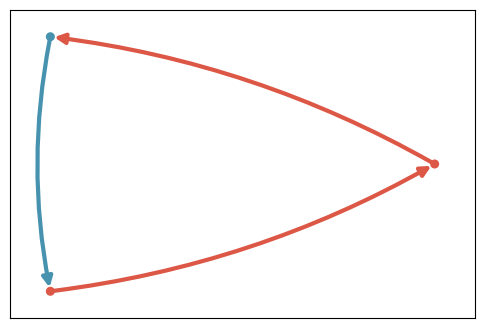

<IPython.core.display.Latex object>

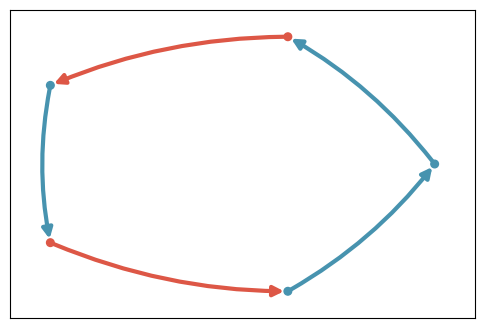

<IPython.core.display.Latex object>

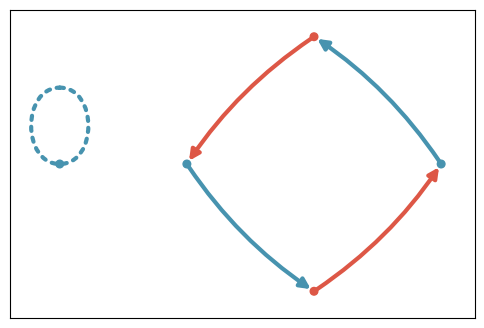

<IPython.core.display.Latex object>

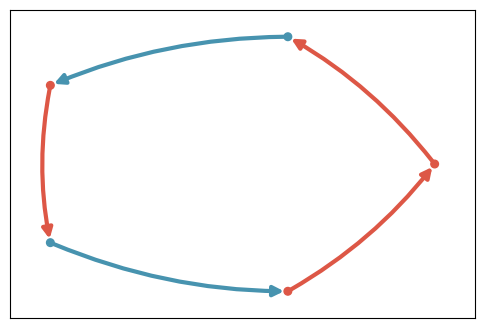

<IPython.core.display.Latex object>

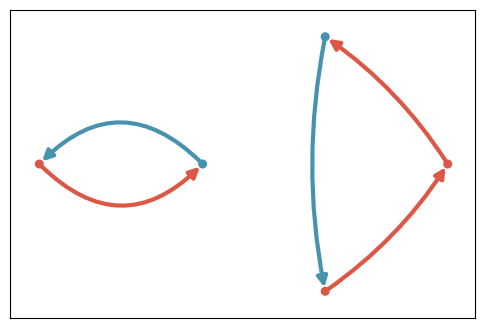

<IPython.core.display.Latex object>

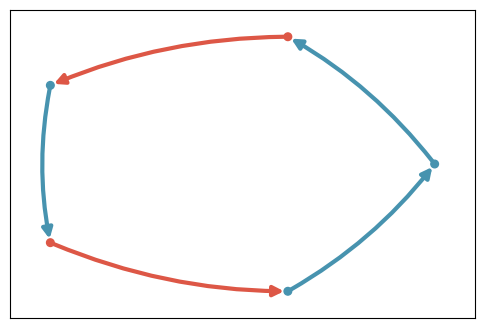

<IPython.core.display.Latex object>

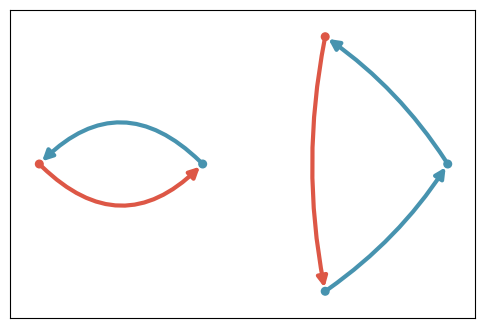

<IPython.core.display.Latex object>

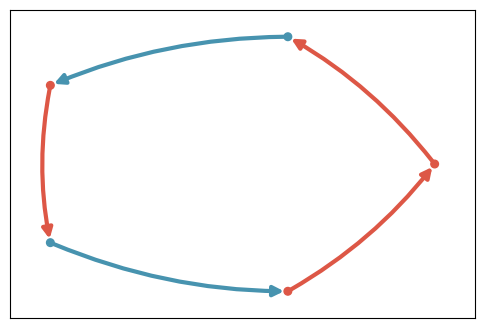

<IPython.core.display.Latex object>

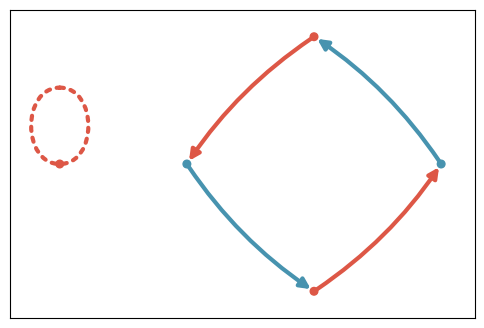

<IPython.core.display.Latex object>

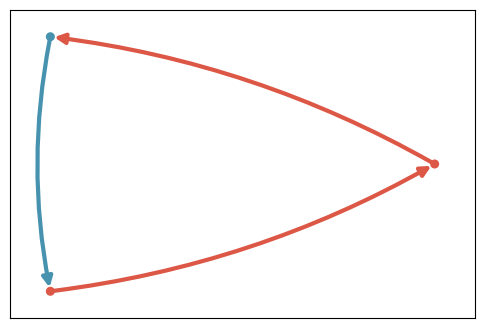

<IPython.core.display.Latex object>

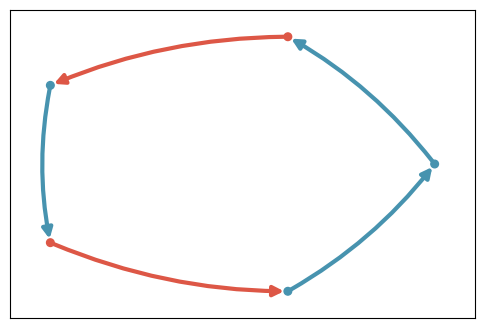

<IPython.core.display.Latex object>

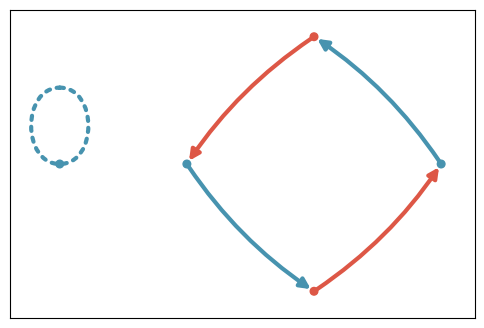

<IPython.core.display.Latex object>

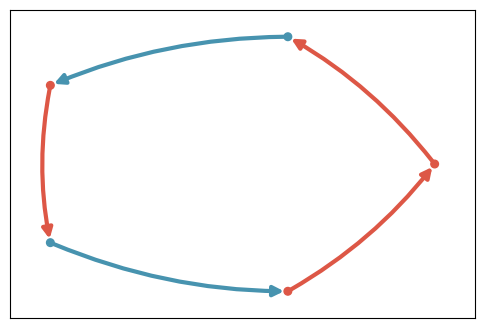

<IPython.core.display.Latex object>

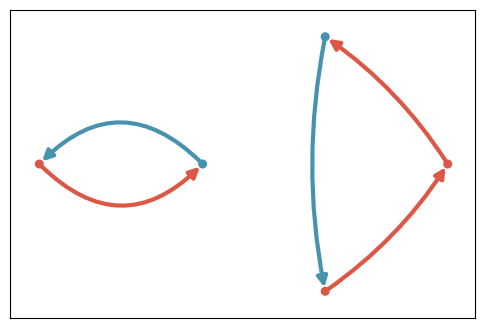

<IPython.core.display.Latex object>

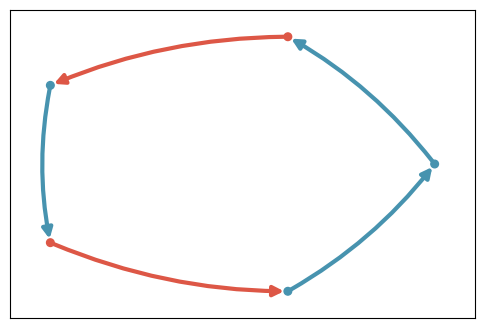

<IPython.core.display.Latex object>

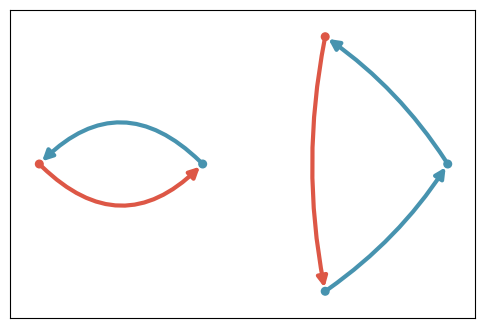

<IPython.core.display.Latex object>

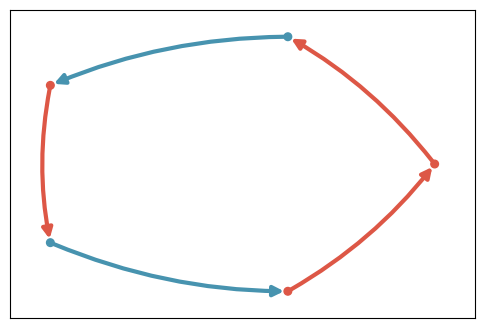

<IPython.core.display.Latex object>

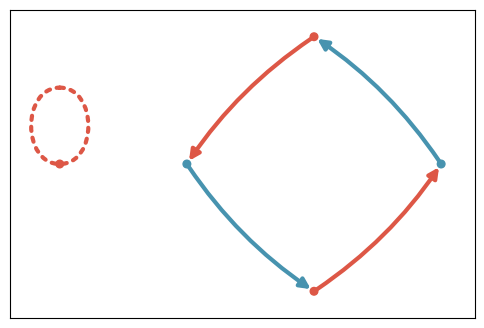

In [95]:
# Visualize resulting graphs from expanding a G-loop
y0 = N(0) * Trace(G(), B(1), conjugate(G()), B(2), G(), B(3), conjugate(G()), B(4))
render(y0)

fig, ax = plt.subplots(figsize=(6, 4))
visualize(y0, ax)
plt.show()


for x in expand_G_loop(y0):
    fig, ax = plt.subplots(figsize=(6, 4))
    visualize(x, ax)

    render(x)
    plt.show()

## Expansion Script


In [13]:
# Expand a G-loop to order 1/N

x0 = N(0) * Trace(
    G(),
    B(1),
    conjugate(G()),
    B(2),
    G(),
    B(3),
    conjugate(G()),
    B(4),
    G(),
    B(5),
    conjugate(G()),
    B(6),
)
m = 1

stack: list[tuple[Graph, int]] = [(x0, 0)]
leading_terms: list[tuple[Graph, int]] = []
small_terms: list[tuple[Graph, int]] = []
n_expansions = {}

while stack:
    next, d = stack.pop()

    next_size = size(next)
    n_exponent, eta_exponent = -next_size.n_exponent, -next_size.eta_exponent

    if n_exponent >= m:
        small_terms.append((next, d))
        n_expansions[d] = n_expansions.get(d, 0) + 1
        continue

    if not next.light_weights and not next.g_loops:
        leading_terms.append((next, d))
        continue

    if next.light_weights:
        for x in expand_light_weight(next):
            stack.append((x, d + 1))
    elif next.g_loops:
        for x in expand_G_loop(next):
            stack.append((x, d + 1))

render(x0)
print("# deterministic graphs: ", len(leading_terms))
print("# smaller graphs:       ", len(small_terms))
print("expansion depths:       ", n_expansions)

<IPython.core.display.Latex object>

# deterministic graphs:  20640
# smaller graphs:        203716
expansion depths:        {1: 16, 2: 252, 3: 936, 4: 3024, 5: 9280, 6: 24960, 7: 52352, 8: 77056, 9: 35840}


## Analysis

In [17]:
# Sort deterministic terms and leftover terms by size in decreasing order
small_terms.sort(key=lambda x: size2(x[0]), reverse=True)
leading_terms.sort(key=lambda x: size2(x[0]), reverse=True)

In [24]:
# Largest size ratio among non-deterministic terms
x = small_terms[0][0]
render(size2(x) / size2(x0), "\\quad", x)

# Largest size ratio among deterministic terms
x = leading_terms[0][0]
render(size2(x) / size2(x0), "\\quad", x)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

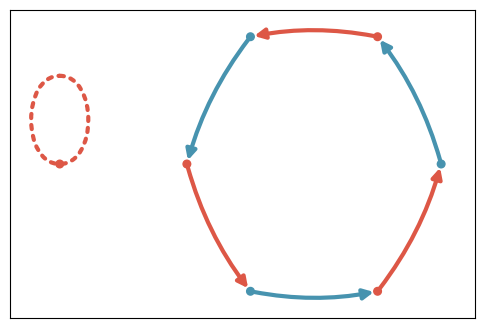

<IPython.core.display.Latex object>

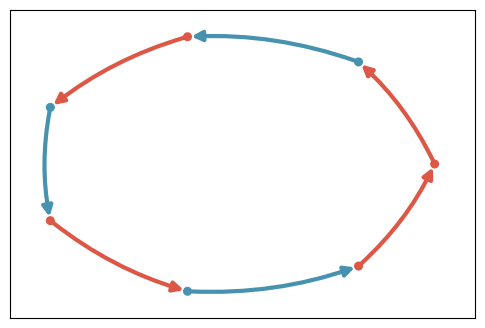

<IPython.core.display.Latex object>

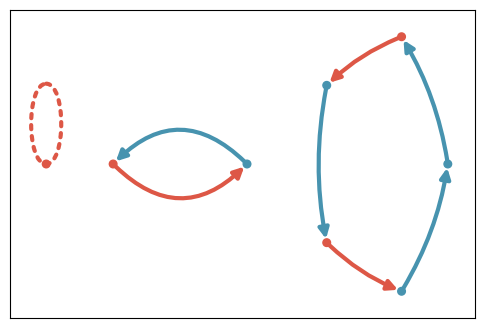

<IPython.core.display.Latex object>

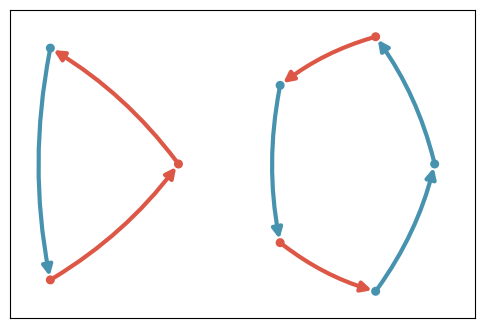

<IPython.core.display.Latex object>

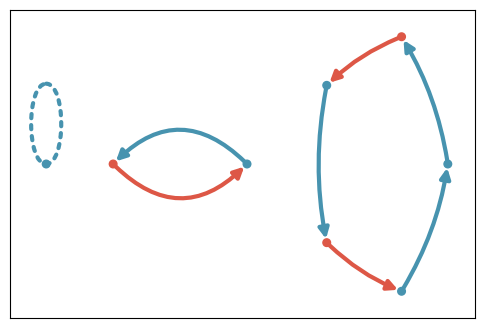

In [94]:
# Draw colored graphs for 5 largest graphs
n_axes = 5
graphs_to_plot = [x for x, _ in small_terms[:n_axes]]

for i, x in enumerate(graphs_to_plot):
    fig, ax = plt.subplots(figsize=(6, 4))
    visualize(x, ax)

    render(x)
    plt.show()